In [1]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
import os
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
#use collagen to define dermis
# 1. extract collagen(class=10) from DLmask
# 2. remove small object and fill holes in collagen to make it a single connected body
# 3. find epidermal-dermis junction using maximum of the binary in y-axis
# 4. remove any pixels that are not epidermis above the epidermal-dermis junction
# 5. iterate each class to replace any potentially wrong pixel to correct class
    #hair foliical:adj pixel look at window

In [7]:
#read deeplab crop
dlcropsrc = r'\\fatherserverdw\kyuex\analysis output\datadst\20220929\dlcrop'

In [8]:
#1. remove small object and fill holes in collagen to make it a single connected body
dl = Image.open(os.path.join(dlcropsrc, "2022-06-07 14.34.59sec1.png"))

In [9]:

dl_arr = np.array(dl)
col = (dl_arr == 10) #collagen

In [10]:
#2.remove small object and fill holes in collagen to make it a single connected body

minTA = 60000
minTAhole = 10000 #is this too much?

#resize to expedite
(width, height) = (dl.width // 10, dl.height // 10)
collagen = Image.fromarray(col).resize((width, height), resample=0)

collagen= closing(collagen, square(3))  # 13sec
collagen= remove_small_objects(collagen, min_size=minTA, connectivity=2)  # 6sec
collagen = remove_small_holes(collagen , area_threshold=minTAhole).astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(collagen .astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
collagen = cv2.dilate(opening, kernel, iterations=3)

#resize back
collagen = Image.fromarray(collagen).resize((dl.width, dl.height),resample=0)
collagen_arr = np.array(collagen)

In [37]:
#3. find epidermal-dermis junction
[xt,yt] = np.where(collagen_arr)


In [40]:
#we actually want to find the minimum x-coordinate (because this image is weirdly oriented)
unique_y = np.unique(yt)


In [41]:

min_x = [np.amin(np.where(collagen_arr[:,y])) for y in unique_y]

In [57]:
thresh = 800 #i'm not sure that this will work with every image. TODO: change

In [58]:
hist, bins = np.histogram(min_x)

In [99]:
#get the value range to remove (note: this doesnt contain last element in bins
remove_bins = [b for h,b in zip(hist,bins) if h < thresh ]

In [100]:
#new junction, remove parts with low frequency in histogram,use remove_bins[0] because it represents where the junction begins to drop
#TODO: need to change this to be more robust, what if the junction drops in the middle,
new_junction_x  = [x for x in min_x if x < np.round(remove_bins[0].astype("uint32"))]
new_junction_y = list(range(len(new_junction_x)))

In [180]:
epi = deepcopy(dl_arr)

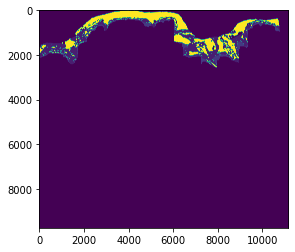

In [184]:

#epi should only have class 1 and 2
for x,y in zip( new_junction_x,new_junction_y):
    epi[x:, y] = 0

epi[collagen == 1] = 0
epi[:,max(new_junction_y):] = 0
plt.imshow(epi)

In [185]:
#?????
epi[epi == 0] = 12

In [ ]:
#question: what is class 12?? background

In [186]:
#iterate through epi and replace value with 1 or 2, ignore 0
window_size = 3

for x in range(max(new_junction_x)):
    for y in range(max(new_junction_y)):
        if not (epi[x,y] == 0 or epi[x,y] == 1 or epi[x,y] == 2 or epi[x,y] == 12):

            #replace pixel value with 1 or 2
            window_shape = [(x -  window_size) if (x -  window_size) >=0 else 0,
                      (x + window_size) , y +  window_size,(y -  window_size) if (y - window_size) >=0 else 0] #L,R,T,B

            window = epi[window_shape[0]:window_shape[1], window_shape[3]:window_shape[2]]
            #check pixel values in window
            count1 = np.sum([window == 1])
            count2 = np.sum([window == 2])


            if(count1 > count2):
                epi[x,y] = 1
            elif (count1 < count2):
                epi[x,y] = 2
            else:
                 epi[x,y] = 0



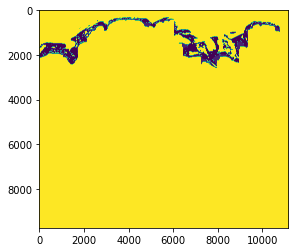

In [187]:
plt.imshow(epi)

In [188]:
np.unique(epi)

array([ 1,  2, 12])

In [507]:
#generate new classification map
new_dl = np.zeros((dl.height,  dl.width))

In [ ]:
# 5. iterate each class to replace any potentially wrong pixel to correct class